## Lab 3: SVM

In [1]:
import os
import mne
import numpy as np
from mne import create_info
from mne.io import RawArray
import torch
from sklearn.preprocessing import StandardScaler

data_path = "D:/Semester5/5.AIS/Lab3_SVM/moabb_data/mne_data"

os.makedirs(data_path, exist_ok=True)

mne.set_config('MNE_DATA', data_path, set_env=True)

mne.set_config('MNE_DATASETS_BRAININVADERS2013_PATH', data_path, set_env=True)

print(mne.get_config())

{'MNE_DATA': 'D:/Semester5/5.AIS/Lab3_SVM/moabb_data/mne_data', 'MNE_DATASETS_BRAININVADERS2013_PATH': 'D:/Semester5/5.AIS/Lab3_SVM/moabb_data/mne_data'}


C:\Users\Admin\AppData\Local\Temp\ipykernel_11224\1671067006.py:15: RuntimeWarning: Setting non-standard config type: "MNE_DATASETS_BRAININVADERS2013_PATH"
  mne.set_config('MNE_DATASETS_BRAININVADERS2013_PATH', data_path, set_env=True)


In [9]:
import moabb
import warnings
from moabb.datasets import BI2013a

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
moabb.set_log_level("info")

print("MNE_DATA =", mne.get_config('MNE_DATA'))
print("MNE_DATASETS_BRAININVADERS2013_PATH =", mne.get_config('MNE_DATASETS_BRAININVADERS2013_PATH'))

m_dataset = BI2013a(NonAdaptive=True, Adaptive=True, Training=True, Online=True)
m_dataset.download()
subjects = m_dataset.subject_list
print(f"Total subjects: {len(subjects)}")

MNE_DATA = D:/Semester5/5.AIS/Lab3_SVM/moabb_data/mne_data
MNE_DATASETS_BRAININVADERS2013_PATH = D:/Semester5/5.AIS/Lab3_SVM/moabb_data/mne_data
Total subjects: 24


In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
from moabb.paradigms import P300
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

paradigm = P300()

# Collect data from all subjects
X_all = []
labels_all = []

for subject in subjects:
    print(f"Processing subject {subject}...")
    X_subj, labels_subj, meta = paradigm.get_data(m_dataset, subjects=[subject])
    X_all.append(X_subj.reshape(X_subj.shape[0], -1))
    labels_all.extend(labels_subj)

# Concatenate all data
X = np.vstack(X_all)
labels = np.array(labels_all)

print("Final dataset shapes:")
print("X shape:", X.shape)
print("Labels shape:", labels.shape)
print("Labels unique values:", np.unique(labels))

label_mapping = {label: idx for idx, label in enumerate(np.unique(labels))}
y = np.array([label_mapping[label] for label in labels])

X = X.reshape(X.shape[0], -1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)

print("\nProcessed data shapes:")
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)
print("Unique labels in training:", torch.unique(y_train))

Processing subject 1...
Processing subject 2...
Processing subject 3...
Processing subject 4...
Processing subject 5...
Processing subject 6...
Processing subject 7...
Processing subject 8...
Processing subject 9...
Processing subject 10...
Processing subject 11...
Processing subject 12...
Processing subject 13...
Processing subject 14...
Processing subject 15...
Processing subject 16...
Processing subject 17...
Processing subject 18...
Processing subject 19...
Processing subject 20...
Processing subject 21...
Processing subject 22...
Processing subject 23...
Processing subject 24...
Final dataset shapes:
X shape: (104208, 8208)
Labels shape: (104208,)
Labels unique values: ['NonTarget' 'Target']


MemoryError: Unable to allocate 1.27 GiB for an array with shape (20842, 8208) and data type float64

In [5]:
class SVM:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=1000, device=None):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None
        self.device = device if device is not None else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.losses = []  # Thêm list để lưu loss

    def fit(self, X, y, batch_size=32):
        X = X.to(self.device)
        y = y.to(self.device)
        n_samples, n_features = X.shape
        self.w = torch.zeros(n_features, dtype=torch.float32, device=self.device)
        self.b = torch.tensor(0.0, dtype=torch.float32, device=self.device)

        y_ = torch.where(y <= 0, -1, 1)

        for epoch in range(self.n_iters):
            indices = torch.randint(0, n_samples, (min(batch_size, n_samples),), device=self.device)
            X_batch = X[indices]
            y_batch = y_[indices]

            linear_pred = torch.mm(X_batch, self.w.unsqueeze(1)).squeeze() + self.b

            # Tính hinge loss
            loss = torch.mean(torch.clamp(1 - y_batch * linear_pred, min=0)) + \
                   self.lambda_param * torch.norm(self.w)
            self.losses.append(loss.item())

            mask = (y_batch * linear_pred <= 1).float()

            dw = self.lr * (1 / len(X_batch)) * torch.mm(X_batch.T, (mask * y_batch).unsqueeze(
                1)).squeeze() - self.lr * self.lambda_param * self.w
            self.w += dw

            db = self.lr * (1 / len(X_batch)) * torch.sum(mask * y_batch)
            self.b += db

    def predict(self, X):
        X = X.to(self.device)
        linear_pred = torch.mm(X, self.w.unsqueeze(1)).squeeze() + self.b
        return torch.sign(linear_pred)

    def decision_function(self, X):
        X = X.to(self.device)
        return torch.mm(X, self.w.unsqueeze(1)).squeeze() + self.b

In [6]:
svm = SVM(learning_rate=0.001, lambda_param=0.01, n_iters=1000, device=device)
svm.fit(X_train, y_train, batch_size=64)

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.89      0.93      1817
           1       0.62      0.94      0.75       363

    accuracy                           0.90      2180
   macro avg       0.81      0.91      0.84      2180
weighted avg       0.93      0.90      0.90      2180



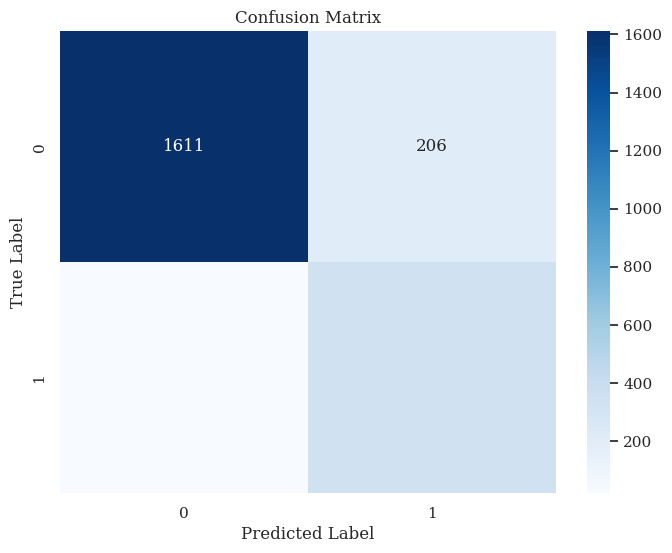


Accuracy: 0.8959


In [7]:
# Evaluate the model
y_pred = svm.predict(X_test).cpu().numpy()
y_true = y_test.cpu().numpy()

# Convert predictions to binary format
y_pred = (y_pred > 0).astype(int)
y_true = (y_true > 0).astype(int)

# Print metrics
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Calculate additional metrics
accuracy = accuracy_score(y_true, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

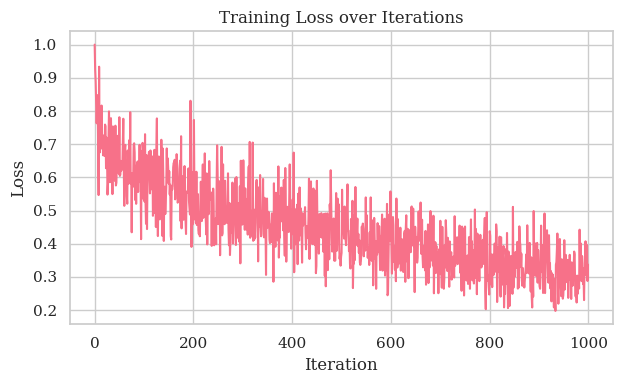

In [8]:
# Visualization cell
plt.figure(figsize=(12, 4))

# Plot 1: Training Loss
plt.subplot(121)
plt.plot(svm.losses)
plt.title('Training Loss over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')

if X_train.shape[1] == 2:
    plt.subplot(122)

    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                        np.arange(y_min, y_max, 0.1))

    # Dự đoán trên lưới điểm
    Z = svm.predict(torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)

    # Vẽ decision boundary
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, alpha=0.8)
    plt.title('Decision Boundary')

plt.tight_layout()
plt.show()